In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, EfficientNetB0, Xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Dataset base directory
dataset_root = r"C:\Users\SujithVarmaMudunuruI\OneDrive - Manipal University Jaipur\Desktop\Big_Dataset\real_vs_fake\real-vs-fake"

In [3]:
# Load CSVs
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("valid.csv")
test_df = pd.read_csv("test.csv")

In [37]:
train_df.head()

,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,C:\Users\SujithVarmaMudunuruI\OneDrive - Manip...
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,C:\Users\SujithVarmaMudunuruI\OneDrive - Manip...
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,C:\Users\SujithVarmaMudunuruI\OneDrive - Manip...
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,C:\Users\SujithVarmaMudunuruI\OneDrive - Manip...
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,C:\Users\SujithVarmaMudunuruI\OneDrive - Manip...


In [38]:
train_df["label"].unique()

array([1, 0], dtype=int64)

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     100000 non-null  int64 
 1   original_path  100000 non-null  object
 2   id             100000 non-null  object
 3   label          100000 non-null  int64 
 4   label_str      100000 non-null  object
 5   path           100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [40]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     20000 non-null  int64 
 1   original_path  20000 non-null  object
 2   id             20000 non-null  object
 3   label          20000 non-null  int64 
 4   label_str      20000 non-null  object
 5   path           20000 non-null  object
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     20000 non-null  int64 
 1   original_path  20000 non-null  object
 2   id             20000 non-null  object
 3   label          20000 non-null  int64 
 4   label_str      20000 non-null  object
 5   path           20000 non-null  object
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


Fake-Generated Images:


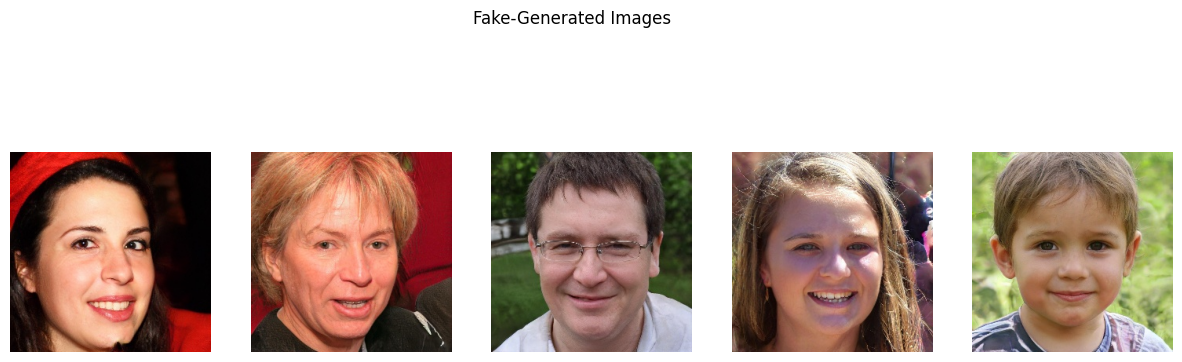

Total images processed: 5

Real Images:


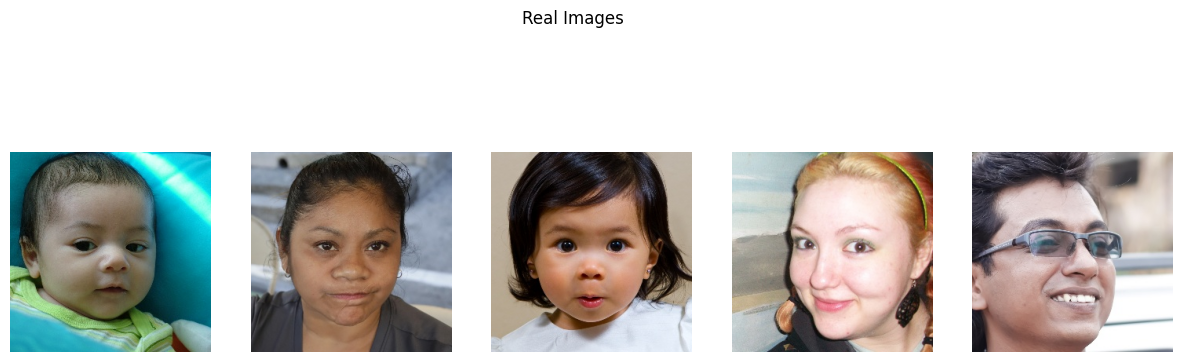

Total images processed: 5


In [4]:
# Data Path
fake_image_dir = r"C:\Users\SujithVarmaMudunuruI\OneDrive - Manipal University Jaipur\Desktop\Big_Dataset\real_vs_fake\real-vs-fake\train\fake"
real_image_dir = r"C:\Users\SujithVarmaMudunuruI\OneDrive - Manipal University Jaipur\Desktop\Big_Dataset\real_vs_fake\real-vs-fake\train\real"

# Function to Show Images
def display_images_from_dir(directory, title, max_images=5):
    images = []
    aspect_ratios = []
    garbage_count = 0
    fig, axes = plt.subplots(1, max_images, figsize=(15, 5))
    
    for idx, filename in enumerate(os.listdir(directory)):
        if idx >= max_images:
            break
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                images.append(img)
                width, height = img.size
                aspect_ratios.append(width / height)
                axes[idx].imshow(img)
                axes[idx].axis("off")
                
        except Exception as e:
            print(f"Error with file {filename}: {e}")
            garbage_count += 1

    plt.suptitle(title)
    plt.show()

    print(f"Total images processed: {min(len(os.listdir(directory)), max_images)}")
    

# Display fake images 
print("Fake-Generated Images:")
display_images_from_dir(fake_image_dir, "Fake-Generated Images")

# Display real images
print("\nReal Images:")
display_images_from_dir(real_image_dir,"Real Images")

In [ ]:
# Build full image paths
train_df["path"] = train_df["path"].apply(lambda x: os.path.join(dataset_root, x))
val_df["path"] = val_df["path"].apply(lambda x: os.path.join(dataset_root, x))
test_df["path"] = test_df["path"].apply(lambda x: os.path.join(dataset_root, x))

In [6]:
# Image parameters
batch_size = 32
img_height, img_width = 128, 128

In [7]:
# Data generators
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# For training: rescaling + augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label_str",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary"
)

Found 100000 validated image filenames belonging to 2 classes.


In [9]:
validation_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="label_str",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary"
)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="label_str",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 20000 validated image filenames belonging to 2 classes.


In [11]:
def build_simple_cnn():
    return Sequential([
        Input(shape=(img_height, img_width, 3)),
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

In [12]:
def build_resnet():
    base = ResNet50(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    return Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

In [13]:
def build_efficientnet():
    base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    return Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

In [14]:
def build_xception():
    base = Xception(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    return Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

In [15]:
def build_mesonet():
    return Sequential([
        Input(shape=(img_height, img_width, 3)),
        Conv2D(8, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(8, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(16, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(16, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(16, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

In [16]:
models = {
    "CNN": build_simple_cnn(),
    "ResNet50": build_resnet(),
    "EfficientNetB0": build_efficientnet(),
    "Xception": build_xception(),
    "MesoNet": build_mesonet()
}

In [17]:
histories = {}
accuracies = {}

for name, model in models.items():
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    histories[name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=5
    )
    loss, acc = model.evaluate(test_generator)
    accuracies[name] = acc

Epoch 1/5
3125/3125 [==============================] - 99s 31ms/step - loss: 0.5300 - accuracy: 0.7322 - val_loss: 0.4070 - val_accuracy: 0.8134
Epoch 2/5
3125/3125 [==============================] - 97s 31ms/step - loss: 0.3543 - accuracy: 0.8458 - val_loss: 0.3020 - val_accuracy: 0.8730
Epoch 3/5
3125/3125 [==============================] - 95s 30ms/step - loss: 0.2624 - accuracy: 0.8927 - val_loss: 0.2318 - val_accuracy: 0.9058
Epoch 4/5
3125/3125 [==============================] - 92s 30ms/step - loss: 0.2084 - accuracy: 0.9165 - val_loss: 0.2036 - val_accuracy: 0.9178
Epoch 5/5
625/625 [==============================] - 21s 33ms/step - loss: 0.1841 - accuracy: 0.9291
Epoch 1/5
3125/3125 [==============================] - 291s 92ms/step - loss: 0.2670 - accuracy: 0.8902 - val_loss: 1.1287 - val_accuracy: 0.6512
Epoch 2/5
3125/3125 [==============================] - 282s 90ms/step - loss: 0.1235 - accuracy: 0.9557 - val_loss: 0.3365 - val_accuracy: 0.8456
Epoch 3/5
3125/3125 [======

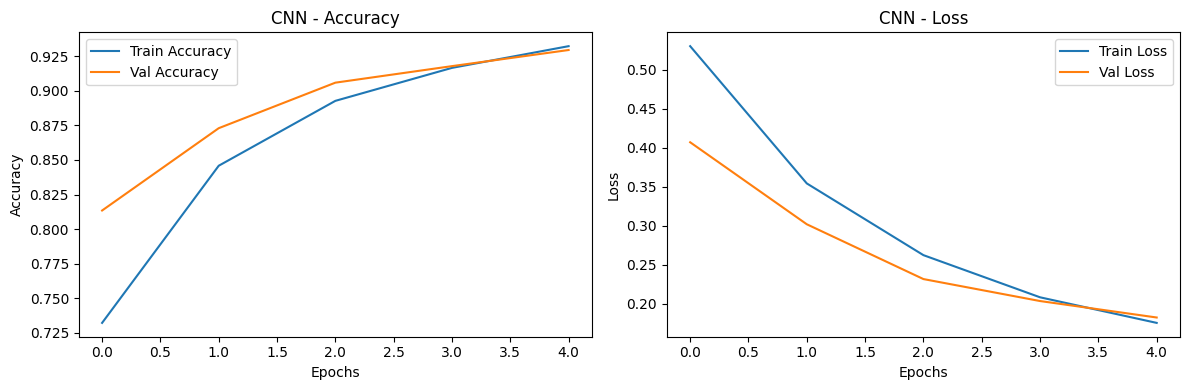

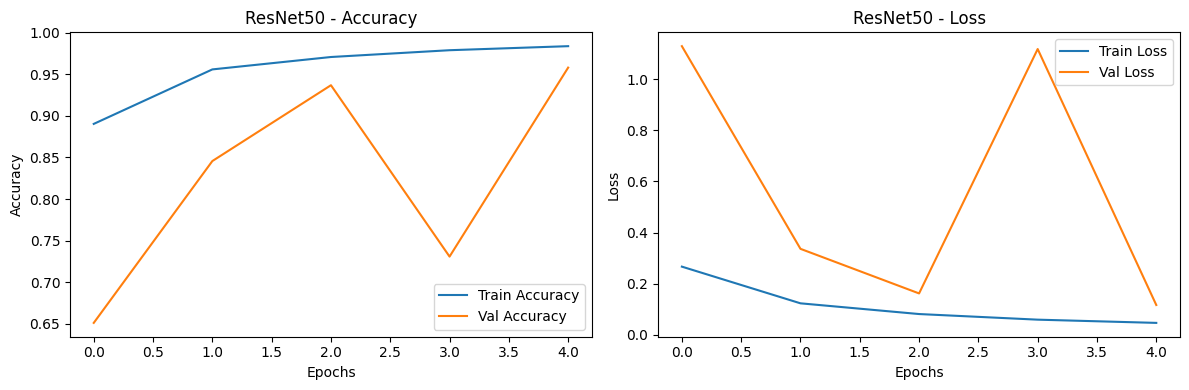

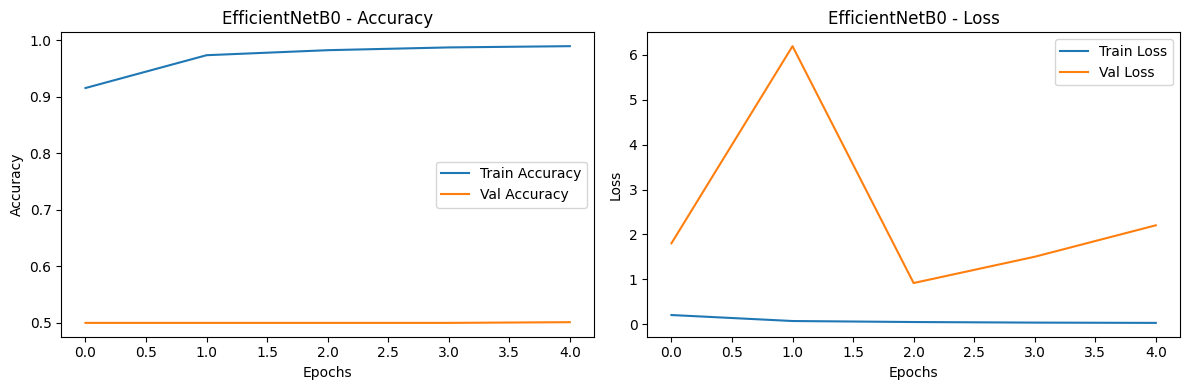

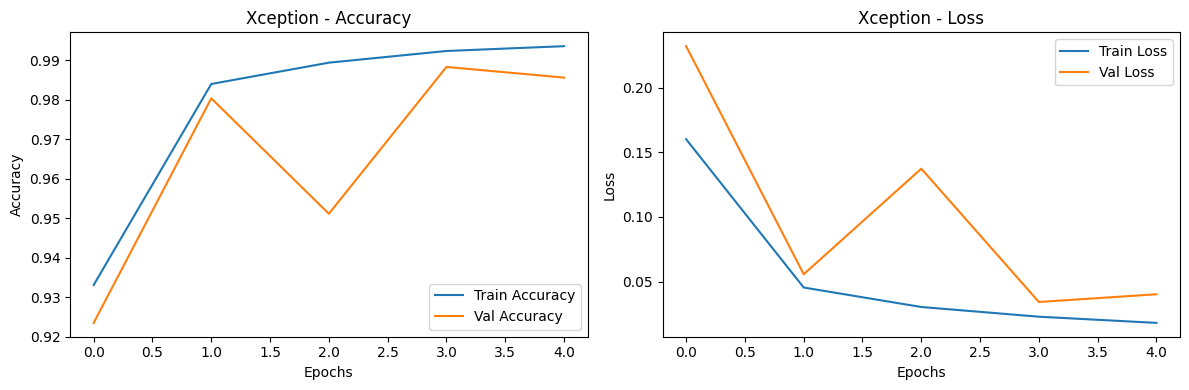

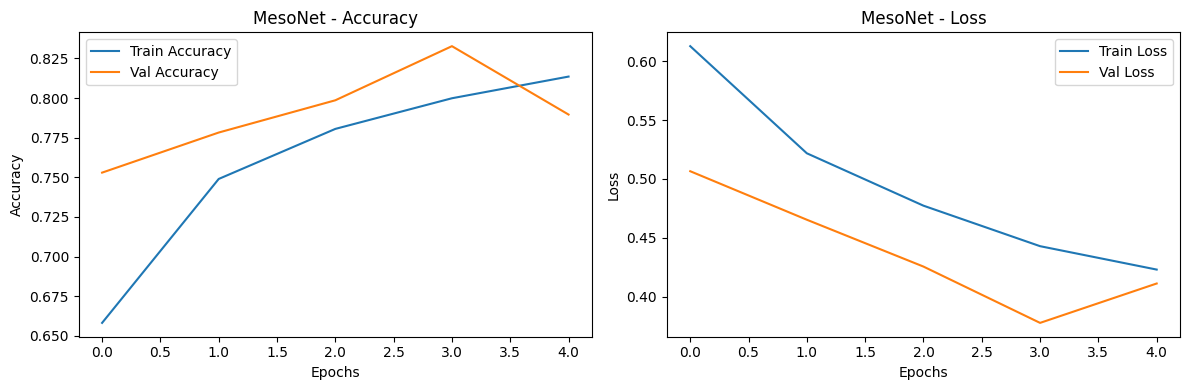

In [18]:
def plot_history(histories):
    for name, history in histories.items():
        plt.figure(figsize=(12, 4))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f"{name} - Accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"{name} - Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_history(histories)

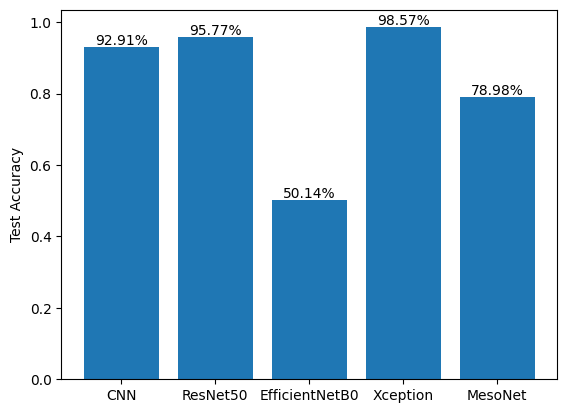

In [19]:
fig, ax = plt.subplots()
bars = ax.bar(accuracies.keys(), accuracies.values())
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height * 100:.2f}%",
        ha="center",
        va="bottom"
    )
ax.set_ylabel("Test Accuracy")
plt.show()


Evaluating CNN...
625/625 [==============================] - 15s 24ms/step
Evaluation Metrics for CNN:
Accuracy:  0.9291
Precision: 0.9159
Recall:    0.9448
F1 Score:  0.9302
AUC-ROC:   0.9791


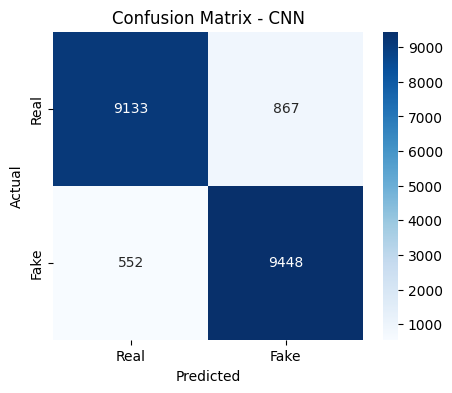


Evaluating ResNet50...
625/625 [==============================] - 17s 26ms/step
Evaluation Metrics for ResNet50:
Accuracy:  0.9577
Precision: 0.9587
Recall:    0.9565
F1 Score:  0.9576
AUC-ROC:   0.9926


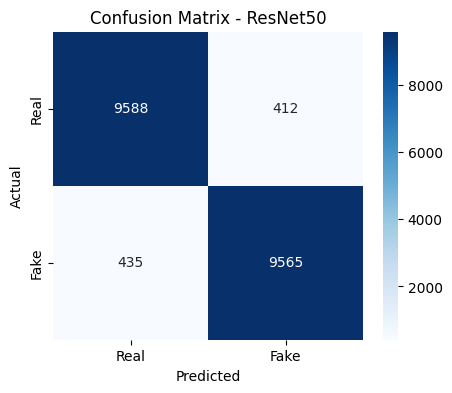


Evaluating EfficientNetB0...
625/625 [==============================] - 17s 26ms/step
Evaluation Metrics for EfficientNetB0:
Accuracy:  0.5014
Precision: 0.5007
Recall:    0.9995
F1 Score:  0.6672
AUC-ROC:   0.5640


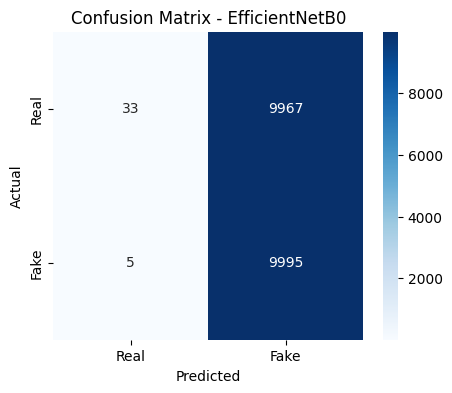


Evaluating Xception...
625/625 [==============================] - 16s 25ms/step
Evaluation Metrics for Xception:
Accuracy:  0.9857
Precision: 0.9837
Recall:    0.9877
F1 Score:  0.9857
AUC-ROC:   0.9990


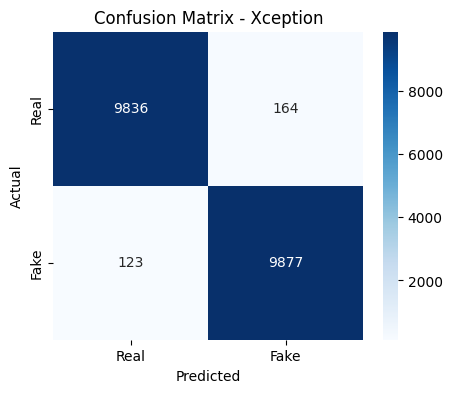


Evaluating MesoNet...
625/625 [==============================] - 15s 25ms/step
Evaluation Metrics for MesoNet:
Accuracy:  0.7898
Precision: 0.9140
Recall:    0.6398
F1 Score:  0.7527
AUC-ROC:   0.9214


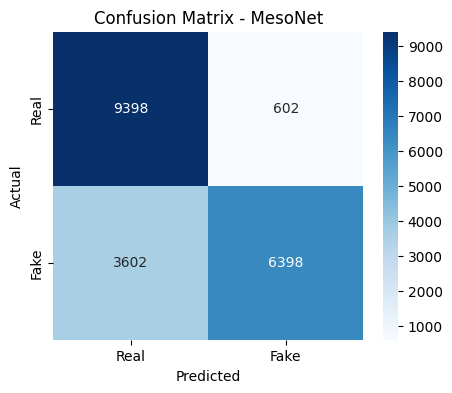

In [20]:
def evaluate_model(model, test_generator, model_name="Model"):
    # Predict probabilities
    y_probs = model.predict(test_generator)
    
    # Convert probabilities to class predictions
    y_pred = (y_probs > 0.5).astype(int).flatten()
    
    # True labels
    y_true = test_generator.classes
    
    # Compute Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    # Print metrics
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return{
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC-ROC":auc
        }
results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, test_generator, model_name=name)

In [23]:
#Saving model
xception_model = models["Xception"]
xception_model.save('xception_model.h5')

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('xception_model.h5')


1/1 [==============================] - 0s 11ms/step


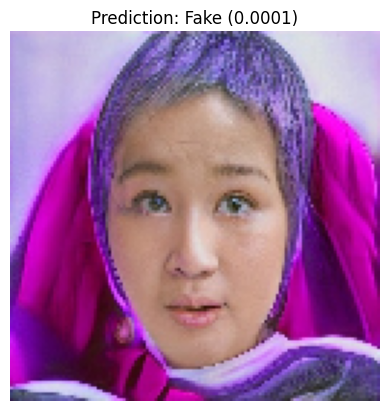

In [ ]:

sample_path = r"C:\Users\SujithVarmaMudunuruI\OneDrive - Manipal University Jaipur\Desktop\Big_Dataset\real_vs_fake\real-vs-fake\train\fake\0C5A51CXL0.jpg"
img = image.load_img(sample_path, target_size=(img_height, img_width))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

pred = model.predict(x)[0][0]
label = "Real" if pred > 0.5 else "Fake"

plt.imshow(img)
plt.title(f"Prediction: {label} ({pred:.4f})")
plt.axis("off")
plt.show()